In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import multiprocessing as mp
from tqdm import tqdm
from itertools import product
from brian2 import us
from utils.modulator import AsynchronousDeltaModulator, modulate, reconstruction_error
from utils.dataset import load_dataset
from utils.plotting import plot_sample_with_reconstruction

# Reconstruction

The original signal can be recovered from the spike trains by the following simple algorithm
```python
Vdc = Vin[0]
Vrec = np.zeros_like(Vin)
for i in range(T):
    if up[i]:
        Vdc = Vdc + Vthrup
    if self.dn[i]:
        Vdc = Vdc - Vthrdn
    rec[i] = Vdc
```
## Example

In [11]:
settings = {
    'mod': 'QPSK',
    'snr': 18,
    'scale': 50,
    'thrup': 0.1,
    'thrdn': 0.1,
    'resampling_factor': 10,
    'stretch_factor': 1000,
}

In [3]:
dataset, classes = load_dataset('./data/radioML/RML2016.10a_dict.pkl', snr=settings['snr'], scale=settings['scale'], normalize=False)

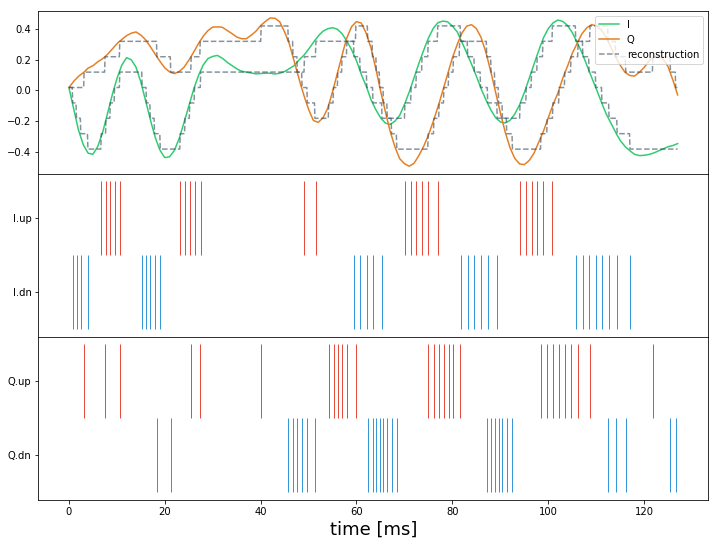

In [12]:
time_sample = np.arange(128)
sample = dataset[(settings['mod'], settings['snr'])][10]
modulators = [
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
]
indices, times, time_stim, signal, reconstruction = modulate(modulators[0], modulators[1], time_sample, sample, \
                                                             resampling_factor=settings['resampling_factor'], \
                                                             stretch_factor=settings['stretch_factor'], reconstruct=True)
plot_sample_with_reconstruction(signal, reconstruction, time_stim*us, indices, times*us, figsize=(12, 9))
#plt.savefig("images/delta-modulator-example.pdf", bbox=plt.tight_layout())

# Reconstruction error

The error $\epsilon_{rec}$ introduced by the conversion into spikes can be computed as the average squared residual

$$
\epsilon_{rec} = \frac{1}{T} \sum_{i=1}^{T}\left(V_{in} - V_{rec}\right)^2.
$$

For this both signals need to be resampled at the same rate.

The reconstruction error of the example above is:

In [13]:
epsilon_rec = reconstruction_error(signal, reconstruction)
print("Reconstruction error: I={}, Q={}".format(epsilon_rec[0], epsilon_rec[1]))

Reconstruction error: I=0.0028862895227864584, Q=0.003369032200815237


We can now explore the effect that the threshold and resampling values have on the reconstruction error. For this we run the conversion and reconstruction algorithm of the sample on a grid of parameters and compute the error at each point.

In [14]:
def yield_grid(X, Y):
    for (i, x) in enumerate(X):
        for (j, y) in enumerate(Y):
            yield (i, j), (x, y)

In [15]:
def evaluate_on_grid(x, y, f):
    pool = mp.Pool(processes=6)
    return pool.map(f, yield_grid(x, y))

In [16]:
def convert_and_reconstruct(args):
    thr, res = args[1]
    modulators = [
        AsynchronousDeltaModulator(thr, thr, res),
        AsynchronousDeltaModulator(thr, thr, res)
    ]
    _, _, _, signal, reconstruction = modulate(modulators[0], modulators[1], time_sample, sample, \
                                               resampling_factor=res, stretch_factor=settings['stretch_factor'], reconstruct=True)
    epsilon_rec = reconstruction_error(signal, reconstruction)
    return args[0], epsilon_rec

In [22]:
T = 50
thresholds = np.linspace(0.001, 0.5, num=T)
resampling_factors = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]) #np.linspace(1, 300, num=R)
R = len(resampling_factors)

In [18]:
reconstruction_errors = evaluate_on_grid(thresholds, resampling_factors, convert_and_reconstruct)

In [23]:
epsilon_rec_I = np.zeros((T, R))
epsilon_rec_Q = np.zeros((T, R))
for e in reconstruction_errors:
    epsilon_rec_I[e[0]]=e[1][0]
    epsilon_rec_Q[e[0]]=e[1][1]

In [20]:
epsilon_rec_max = np.max([epsilon_rec_I.max(), epsilon_rec_Q.max()])

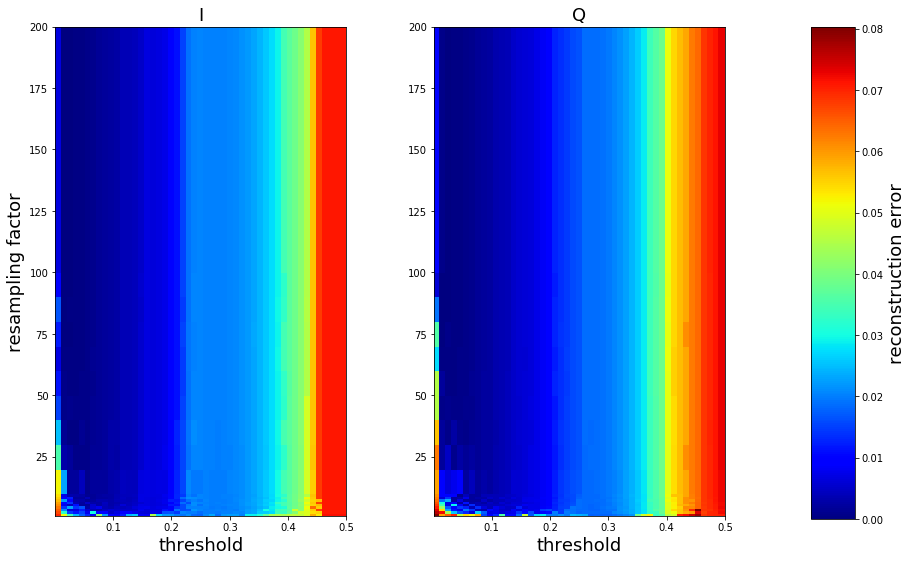

In [24]:
fig = plt.figure(figsize=(12, 9))
grid = grs.GridSpec(1, 2, wspace=0.3)
ax1 = plt.Subplot(fig, grid[0])
ax1.pcolor(thresholds, resampling_factors, epsilon_rec_I.T, cmap="jet", vmin=0.0, vmax=epsilon_rec_max)
ax1.set_xlabel("threshold", fontsize=18)
ax1.set_ylabel("resampling factor", fontsize=18)
ax1.set_title("I", fontsize=18)
ax2 = plt.Subplot(fig, grid[1])
im = ax2.pcolor(thresholds, resampling_factors, epsilon_rec_Q.T, cmap="jet", vmin=0.0, vmax=epsilon_rec_max)
ax2.set_xlabel("threshold", fontsize=18)
ax2.set_title("Q", fontsize=18)
ax_cbar = fig.add_axes([1, 0.12, 0.05, 0.76])
cb = plt.colorbar(im, cax=ax_cbar)
cb.set_label(label="reconstruction error", fontsize=18)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
#plt.savefig("images/reconstruction-error-example.pdf", bbox_inches="tight")

Let's now compare the reconstruction error across the entire dataset for fixed parameter values. We set:
- `thrup=0.1`
- `thrdn=0.1`
- `resampling_factor=200`

In [25]:
def evaluate_on_class(samples, f):
    pool = mp.Pool(processes=6)
    result = pool.map(f, enumerate(samples))
    result = sorted(result, key=lambda x: x[0])
    return result

In [26]:
def convert_and_reconstruct_sample(args):
    modulators = [
        AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
        AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
    ]
    _, _, _, signal, reconstruction = modulate(modulators[0], modulators[1], time_sample, args[1], \
                                               resampling_factor=settings['resampling_factor'], \
                                               stretch_factor=settings['stretch_factor'], reconstruct=True)
    epsilon_rec = reconstruction_error(signal, reconstruction)
    return args[0], epsilon_rec

In [27]:
C = len(classes)
S = len(dataset[(settings['mod'], settings['snr'])])
reconstruction_errors = np.zeros((C, S, 2))
mods = []
for (i, c) in tqdm(enumerate(classes)):
    samples = dataset[c]
    mods.append(c[0])
    result = evaluate_on_class(samples, convert_and_reconstruct_sample)
    for e in result:
        reconstruction_errors[i, e[0], :] = e[1]

11it [00:14,  1.27s/it]


In [28]:
epsilon_rec_max = np.max(reconstruction_errors)

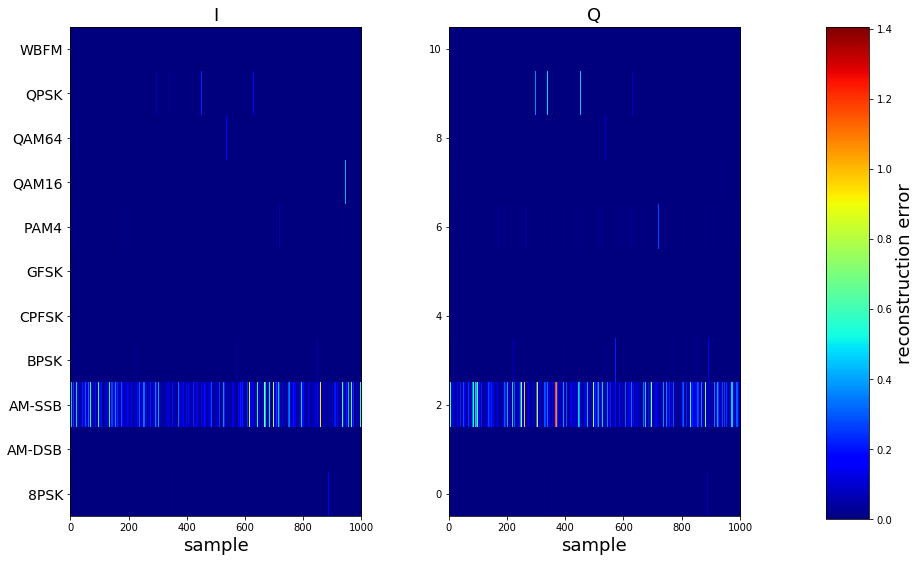

In [29]:
fig = plt.figure(figsize=(12, 9))
grid = grs.GridSpec(1, 2, wspace=0.3)
ax1 = plt.Subplot(fig, grid[0])
ax1.imshow(reconstruction_errors[:, :, 0], origin="low", cmap="jet", aspect="auto", vmin=0.0, vmax=epsilon_rec_max)
ax1.set_yticks(np.arange(C))
ax1.set_yticklabels(mods, rotation=0, fontsize=14)
ax1.set_xlabel("sample", fontsize=18)
ax1.set_title("I", fontsize=18)
ax2 = plt.Subplot(fig, grid[1])
im = ax2.imshow(reconstruction_errors[:, :, 1], origin="low", cmap="jet", aspect="auto", vmin=0.0, vmax=epsilon_rec_max)
ax2.set_xlabel("sample", fontsize=18)
ax2.set_title("Q", fontsize=18)
ax_cbar = fig.add_axes([1, 0.12, 0.05, 0.76])
cb = plt.colorbar(im, cax=ax_cbar)
cb.set_label(label="reconstruction error", fontsize=18)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
plt.savefig("images/reconstruction-error-dataset.pdf", bbox_inches="tight")